## Introduction

Here I will be working with our edited Reddit-Dataframe from the previous journals. For this journal I will tokenize and CountVectorize the Reddit comments, then apply some modeling. I will do a Logisitic Regression model, then a Decission Tree Classifier with a pipeline and GridSearch for best parameters.

Let's load in our libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

And our dataset. This is the kaggle dataset from Reddit that we edited in the previous journals

In [2]:
df = pd.read_csv('/Users/lokikeeler/Downloads/train-balanced-sarcasm_2.csv')

In [3]:
df.head()

,label,comment,score,ups,downs,date,created_utc,parent_comment,year,SUB_2007scape,...,SUB_television,SUB_tf2,SUB_todayilearned,SUB_trees,SUB_ukpolitics,SUB_unitedkingdom,SUB_videos,SUB_worldnews,SUB_wow,SUB_xboxone
0,0,NC and NH.,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016,False,...,False,False,False,False,False,False,False,False,False,False
1,0,You do know west teams play against west teams...,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016,False,...,False,False,False,False,False,False,False,False,False,False
2,0,"They were underdogs earlier today, but since G...",3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016,False,...,False,False,False,False,False,False,False,False,False,False
3,0,"This meme isn't funny none of the ""new york ni...",-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016,False,...,False,False,False,False,False,False,False,False,False,False
4,0,"I don't pay attention to her, but as long as s...",0,0,0,2016-09-01,2016-09-02 10:35:08,do you find ariana grande sexy ?,2016,False,...,False,False,False,False,False,False,False,False,False,False


For this journal I will just be working with the comment, so I will drop the parent comment for now (but we may introduce it for further models later on)

In [4]:
df = df.drop(columns='parent_comment')

Now I will take a 10% sample of the data since the kernel was taking too long

In [5]:
random_seed = 42

In [6]:
df_sample = df.sample(frac=0.1, random_state=random_seed)

We are ready to tokenize and vectorize our comments. Below is our custom tokenizer which seperates the sentences into separate words, removes stop-words (and, the, but, if, etc.), removes punctuation marks, makes every word lowercase, and stems words (for example, running is considered as run)

In [7]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    stemmer = nltk.stem.PorterStemmer()
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words  


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lokikeeler/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We will make X all variables that are not Label, and y our Label (sarcastic or not sarcastic). Then we will do a train/test split.

In [8]:
X = df_sample.drop(columns='label')
y = df_sample['label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Perfect. Now we will use a CountVectorizer with our tokenizer to tokenize the words, and create a library of our tokens based on the counts of the tokens. After we fit this CountVectorizer on the X_Train comments, we will transform the both the Train and Test set of comments

In [10]:
bagofwords = CountVectorizer(tokenizer=my_tokenizer, min_df=10, max_features=500)

bagofwords.fit(X_train['comment'])

/Users/lokikeeler/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(max_features=500, min_df=10,
                tokenizer=<function my_tokenizer at 0x134741080>)

In [11]:
count_matrix_train_comment = bagofwords.transform(X_train['comment'])
count_matrix_test_comment = bagofwords.transform(X_test['comment'])

print(count_matrix_train_comment.shape);

(38493, 500)


We are now ready to convert these transformed train and test set of comments back to the original dataframe. To do this we will transform our sparse matrix into a dense matrix so it can be put into a dataframe, then we will merge the dataframes with the original Train and Test dataframes.

In [12]:
my_comment_train_df = pd.DataFrame(columns=bagofwords.get_feature_names_out(),
                               data=count_matrix_train_comment.toarray(),
                                   index = X_train.index)
display(my_comment_train_df)

,1,10,100,2,20,3,30,4,5,abl,...,ya,ye,yea,yeah,year,yep,yet,youll,your,yup
315731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437713,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
353853,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
370987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
232916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146442,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279814,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
335387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train_new = pd.concat([X_train, my_comment_train_df], axis=1)

In [14]:
X_train_new.head()

,comment,score,ups,downs,date,created_utc,year,SUB_2007scape,SUB_AdviceAnimals,SUB_Android,...,ya,ye,yea,yeah,year,yep,yet,youll,your,yup
315731,Why would they have made the list when they ha...,-9,-9,0,2015-12-01,2015-12-23 17:57:03,2015,False,False,False,...,0,0,0,0,0,0,0,0,0,0
437713,"Pssst, OP, I think you missed the part where y...",1,1,0,2014-08-01,2014-08-06 03:46:34,2014,False,False,False,...,0,0,0,0,0,0,0,0,0,0
353853,The economy is in better shape the when the re...,7,7,0,2015-02-01,2015-02-22 17:30:26,2015,False,False,False,...,0,0,0,0,0,0,0,0,0,0
370987,"BUT GUYS THIS CANT BE TRUE, THIS GAME IS PAY T...",6,6,0,2015-01-01,2015-01-13 18:42:19,2015,False,False,False,...,0,0,0,0,0,0,0,0,0,0
232916,Which at times had a Cavalier steering wheel.,2,2,0,2016-03-01,2016-03-31 14:33:29,2016,False,False,False,...,0,0,0,0,0,0,0,0,0,0


Nice. Now let's drop the original comment column, as well as created_utc and date column since we have a year column already

In [15]:
X_train_ready = X_train_new.drop(columns=['comment', 'created_utc', 'date'])
X_train_ready.head()

,score,ups,downs,year,SUB_2007scape,SUB_AdviceAnimals,SUB_Android,SUB_AskMen,SUB_AskReddit,SUB_BigBrother,...,ya,ye,yea,yeah,year,yep,yet,youll,your,yup
315731,-9,-9,0,2015,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
437713,1,1,0,2014,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
353853,7,7,0,2015,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
370987,6,6,0,2015,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
232916,2,2,0,2016,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


We repeat the process for the Test set

In [16]:
my_comment_test_df = pd.DataFrame(columns=bagofwords.get_feature_names_out(),
                               data=count_matrix_test_comment.toarray(),
                                   index = X_test.index)
display(my_comment_test_df)

,1,10,100,2,20,3,30,4,5,abl,...,ya,ye,yea,yeah,year,yep,yet,youll,your,yup
161095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236512,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359565,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
17028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
257878,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
381974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X_test_new = pd.concat([X_test, my_comment_test_df], axis=1)

In [18]:
X_test_ready = X_test_new.drop(columns=['comment', 'created_utc', 'date'])
X_test_ready.head()

,score,ups,downs,year,SUB_2007scape,SUB_AdviceAnimals,SUB_Android,SUB_AskMen,SUB_AskReddit,SUB_BigBrother,...,ya,ye,yea,yeah,year,yep,yet,youll,your,yup
161095,1,1,0,2016,False,False,False,False,True,False,...,0,0,0,0,0,0,0,0,0,0
236512,6,6,0,2016,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
130611,11,11,0,2016,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
359565,4,4,0,2015,False,False,False,False,False,False,...,0,1,0,0,0,0,0,0,0,0
17028,16,16,0,2016,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0


We're ready to plug in our data into a Logistic Regression Model

In [19]:
np.random.seed(123)

# Fitting a model
logreg = LogisticRegression()
logreg.fit(X_train_ready, y_train)

# Training and test score
print(f"Train score: {logreg.score(X_train_ready, y_train)}")
print(f"Test score: {logreg.score(X_test_ready, y_test)}")

/Users/lokikeeler/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train score: 0.6544566544566545
Test score: 0.6453900709219859


Great! This is an improvement from the 55-57% we received from the Logistic model we ran on our binary columns in the previous journal

Now let's see which words indicate sarcasm the most. We can do this by pulling up a dataframe of the coeffients of our variables from the logistic model, sorting the coefficients and producing the top 20

In [20]:
coef_df = pd.DataFrame({'variable':logreg.feature_names_in_, 'coef':logreg.coef_[0]})
coef_df.head()

,variable,coef
0,score,0.009202
1,ups,-0.025925
2,downs,0.312922
3,year,-0.000024
4,SUB_2007scape,-0.211523


In [21]:
coef_df.sort_values(by = 'coef', ascending=False)

,variable,coef
269,forgot,2.235223
410,obvious,1.906497
546,total,1.680529
188,clearli,1.462060
54,SUB_creepyPMs,1.435920
...,...,...
370,lot,-0.779004
324,id,-0.784982
120,agre,-0.788315
125,also,-0.844143


In [32]:
comment_sarcasm_words = coef_df.nlargest(20, 'coef')
comment_sarcasm_words

,variable,coef
269,forgot,2.235223
410,obvious,1.906497
546,total,1.680529
188,clearli,1.462060
54,SUB_creepyPMs,1.435920
596,yeah,1.287831
522,sure,1.237780
456,racist,1.146663
591,wow,1.146231
594,ye,1.108773


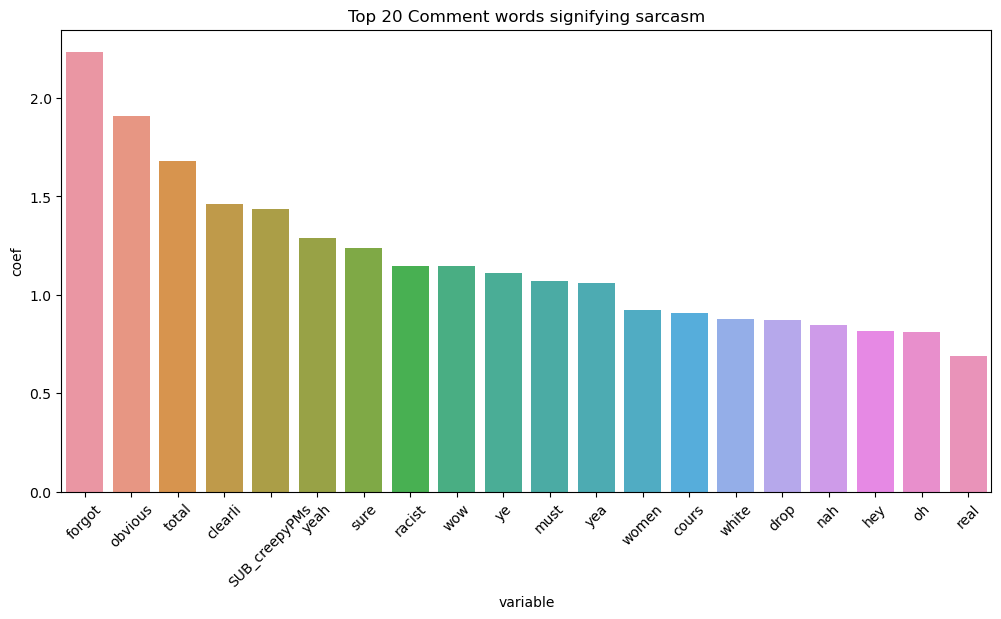

In [33]:
plt.figure(figsize=(12,6))
sns.barplot(x = 'variable', y = 'coef', data=comment_sarcasm_words) 
plt.title("Top 20 Comment words signifying sarcasm")
plt.ylabel("coef")
plt.xticks(rotation=45)
plt.show()

Amazing. Here we can see that Forgot, Obvious, and Total (probably stemmed from totally), are indicators of sarcasm based on the counts they appear. 

Now let's try this with a Decision Tree Classifier. We will also use a Pipeline with a Scaler and a GridSearch to see what our best parameters are. For our hyperparameters, let's try Model Max Depth and Min Samples Leaf

In [34]:
estimators = [
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier())
]

my_pipe = Pipeline(estimators)

In [35]:
 param_grid = [
{
        'scaler': [StandardScaler()],
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [4, 8, 10],
        'model__min_samples_leaf': [2, 10],
    }  
 ]
    
grid = GridSearchCV(my_pipe, param_grid, cv=5)

In [36]:
fittedgrid = grid.fit(X_train_ready, y_train)

In [37]:
fittedgrid.best_params_

{'model': DecisionTreeClassifier(max_depth=10, min_samples_leaf=10),
 'model__max_depth': 10,
 'model__min_samples_leaf': 10,
 'scaler': StandardScaler()}

In [38]:
fittedgrid.score(X_test_ready, y_test)

0.5742256167788082

Hmmm. Our accuracy is pretty low, and our best hyperparameters were at the end of their range. Let's re run this with a higher range on our hyperparameters

In [39]:
 param_grid_2 = [
{
        'scaler': [StandardScaler()],
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [4, 8, 10, 16, 32],
        'model__min_samples_leaf': [2, 10, 20],
    }  
 ]
    
grid_2 = GridSearchCV(my_pipe, param_grid_2, cv=5)

In [40]:
fittedgrid_2 = grid_2.fit(X_train_ready, y_train)

In [41]:
fittedgrid_2.best_params_

{'model': DecisionTreeClassifier(max_depth=32, min_samples_leaf=20),
 'model__max_depth': 32,
 'model__min_samples_leaf': 20,
 'scaler': StandardScaler()}

In [42]:
fittedgrid_2.score(X_test_ready, y_test)

0.6013214523852821

Here we can see our optimal parameters increased as our range increased. Also, our accuracy increased by 3%. It still wasn't as good as our Logistic Regression model, but perhaps the precision and recall scores are better

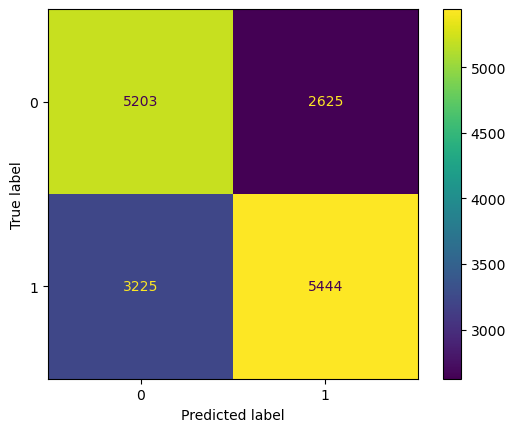

In [43]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_ready, y_test)

In [44]:
y_pred = logreg.predict(X_test_ready)
precision_score(y_test, y_pred)

0.6746808774321478

In [45]:
recall_score(y_test, y_pred)

0.6279847733302573

Above are the scores from our Logistic Regression Model. We are correctly predicting sarcasm 67% of the time, but our recall shows that out of all our sarcastic predictions, only 63% of them are correct. Let's compare this to our Decision Tree model with the GridSearch

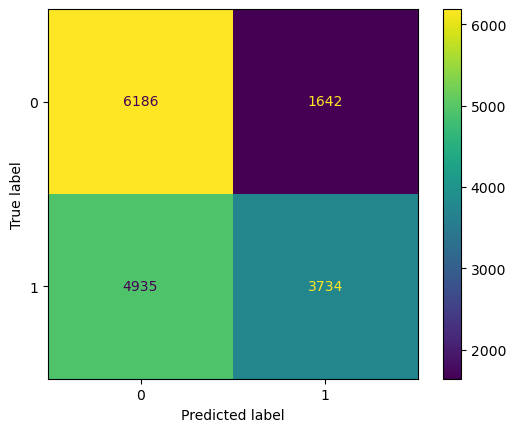

In [46]:
ConfusionMatrixDisplay.from_estimator(fittedgrid_2, X_test_ready, y_test)

In [47]:
y_pred_grid = fittedgrid_2.predict(X_test_ready)
precision_score(y_test, y_pred_grid)

0.6945684523809523

In [48]:
recall_score(y_test, y_pred_grid)

0.4307301880263006

Wow. As we were able to increase our precision a little bit, our recall went way down. Based on these numbers, it seems our model is way worse. It seems that the parameters on our Decision Tree Classifier made the model guess that the comments were not sarcastic way more often, being much more conservative with our approved sarcasm. This helped correctly predict much more non-sarcastic comments, which increased precision, but failed to correctly guess sarcasm over half of the time!

## Conclusion

We tokenized and CountVectorized the dataset. After this we were able to run some initial Logistic Regression Models and a Decision Tree Classifier. Our Logistic model seemed to outperform our Decision Tree model in accuracy and recall. In fact, our Decision Tree model seemed to be much more conservative in its sarcastic predictions, and got many of its positive sarcasm predictions.

 For the next journal I will try to improve these models by using a TF-IDF instead of a Count Vectorizer, tweak the tokenizer, and improve both models